In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
## This notebook tests the hypothesis presented in this document:
##  https://www.overleaf.com/project/6646149ffbda4a6cc359244d

In [28]:
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

In [29]:
class Buyer:
    def __init__(self, id):
        self.id = 'Buyer_' + str(id)

class Seller:
    def __init__(self, id):
        self.id = 'Seller_' + str(id)
        self.fees_vec = []
        self.total_fees_vec = []
        self.total_weight_vec = []

    def step(self, fees = 0, weight = 0):
        self.update_fees_paid(fees)
        self.update_weight(weight)

    def update_fees_paid(self, fees):
        self.fees_vec.append(fees)
        if len(self.total_fees_vec) == 0:
            self.total_fees_vec.append(fees)
        else:
            total_fees_paid = self.total_fees_vec[-1] + fees
            self.total_fees_vec.append(total_fees_paid)

    def update_weight(self, new_total_weight):
        self.total_weight_vec.append(new_total_weight)

    def __str__(self):
        return f"ID: {self.id}, Fees Paid: {self.fees_paid}, Total Weight: {self.total_weight}"

class DynamicSimulation:
    def __init__(self, 
                 n_buyers=10, 
                 p=0.6,
                 augmentation_fee_pct=0.0,
                 seed=123):
        self.rng = np.random.default_rng(seed)
        # create a blank graph representation of the network
        self.graph = nx.Graph()

        self.p = p
        self.augmentation_fee_pct = augmentation_fee_pct

        # create N buyers
        self.n_buyers = n_buyers
        self.buyers = [Buyer(i) for i in range(n_buyers)]

        # create two producers
        self.sellers = [Seller(i) for i in range(2)]

    def transaction_value_to_fees(self, transaction_value):
        tx_value_to_seller = 0.9 * transaction_value      # this is just what is transferred to the seller from the buyer
                                                          # for purposes of this simulation, a noop
        total_fee_paid = 0.1 * transaction_value
        augmentation_fee = self.augmentation_fee_pct * total_fee_paid
        fees_for_redistribution = total_fee_paid - augmentation_fee  # gets redistributed to the other sellers
        return total_fee_paid, augmentation_fee, fees_for_redistribution

    def step(self):
        buyer = self.rng.choice(self.buyers)
        transaction_value = self.rng.uniform(0, 1)
        total_fee_paid, augmentation_fee, fees_for_redistribution = self.transaction_value_to_fees(transaction_value)

        transact_with_highly_connected_seller = self.rng.uniform(0, 1) < self.p
        if transact_with_highly_connected_seller:
            seller = self.sellers[0]
            other_seller = self.sellers[1]
        else:
            seller = self.sellers[1]
            other_seller = self.sellers[0]

        ####### Redistribution of fees to other sellers ########
        # compute how much of the fee_for_redistribution goes to each seller
        # compute the strength of each seller to the buyer of the transaction
        seller_buyer_current_weight = self.graph[seller][buyer]['seller_weight'] if self.graph.has_edge(seller, buyer) else 0
        other_seller_buyer_current_weight = self.graph[other_seller][buyer]['seller_weight'] if self.graph.has_edge(other_seller, buyer) else 0
        total_weight = seller_buyer_current_weight + other_seller_buyer_current_weight
        if total_weight == 0:
            fee_for_transacting_seller = fees_for_redistribution
            fee_for_other_seller = 0
        else:
            fee_for_transacting_seller = seller_buyer_current_weight / total_weight * fees_for_redistribution
            fee_for_other_seller = other_seller_buyer_current_weight / total_weight * fees_for_redistribution
        assert fees_for_redistribution == sum([fee_for_transacting_seller, fee_for_other_seller])
        ########################################################

        # update graph with the new transaction
        if self.graph.has_edge(seller, buyer):
            self.graph[seller][buyer]['buyer_weight'] += augmentation_fee
            self.graph[seller][buyer]['seller_weight'] += fee_for_transacting_seller
        else:
            self.graph.add_edge(seller, buyer, buyer_weight=augmentation_fee, seller_weight=fee_for_transacting_seller)
        
        if self.graph.has_edge(other_seller, buyer):
            self.graph[buyer][other_seller]['buyer_weight'] += augmentation_fee
            self.graph[buyer][other_seller]['seller_weight'] += fee_for_other_seller
        else:
            self.graph.add_edge(other_seller, buyer, buyer_weight=augmentation_fee, seller_weight=fee_for_other_seller)
        
        # TODO: update variables
        # get the total weight of the seller, and set the attribute for easy access
        new_total_weight_seller = sum([self.graph[seller][buyer]['seller_weight'] for buyer in self.buyers if self.graph.has_edge(seller, buyer)])
        new_total_weight_other_seller = sum([self.graph[other_seller][buyer]['seller_weight'] for buyer in self.buyers if self.graph.has_edge(other_seller, buyer)])

        # step the agents for plotting
        seller.step(fees=total_fee_paid, weight=new_total_weight_seller)
        other_seller.step(fees=0, weight=new_total_weight_other_seller)
        

    def run(self, n_steps=100):
        for ii in range(n_steps):
            self.step()

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_4873/3007134717.py:23: RuntimeWarning: invalid value encountered in divide
  results_seller2.append(np.array(ds.sellers[1].total_fees_vec) / np.array(ds.sellers[1].total_weight_vec))
/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_4873/3007134717.py:22: RuntimeWarning: divide by zero encountered in divide
  results_seller1.append(np.array(ds.sellers[0].total_fees_vec) / np.array(ds.sellers[0].total_weight_vec))
/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_4873/3007134717.py:22: RuntimeWarning: invalid value encountered in divide
  results_seller1.append(np.array(ds.sellers[0].total_fees_vec) / np.array(ds.sellers[0].total_weight_vec))
/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_4873/3007134717.py:23: RuntimeWarning: divide by zero encountered in divide
  results_seller2.append(np.array(ds.sellers[1].total_fees_vec) / np.array(ds.sellers[1].total_weight_vec))
/var/folders/nz/szh1vbf12cd7rw

(3, 1000) (3, 1000)
(3, 1000) (3, 1000)


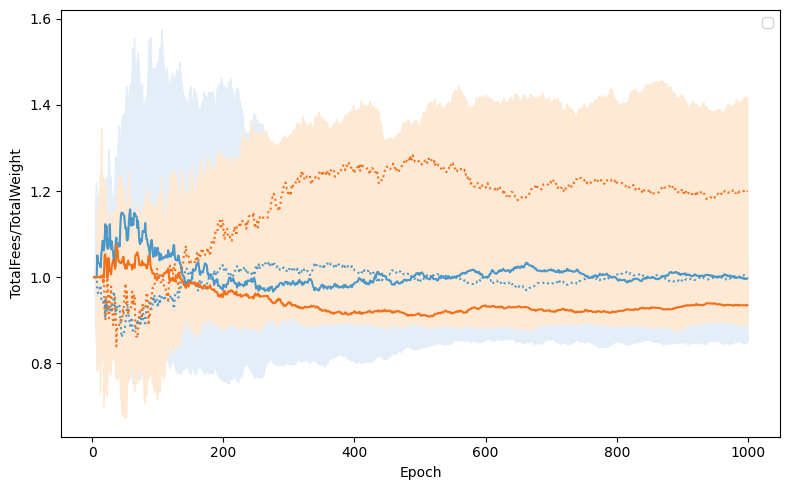

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

n_buyers = 20
p_vec = [0.5, 0.7]
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
linestyles = ['-', ':']
augmentation_fee_pct = 0.0
n_steps = 1000
num_mc = 20
for ii, p in enumerate(p_vec):
    results_seller1 = []
    results_seller2 = []
    for jj in range(num_mc):
        ds = DynamicSimulation(
            n_buyers=n_buyers, 
            p=p,
            augmentation_fee_pct=augmentation_fee_pct,
            seed=123+jj
        )
        ds.run(n_steps=n_steps)

        results_seller1.append(np.array(ds.sellers[0].total_fees_vec) / np.array(ds.sellers[0].total_weight_vec))
        results_seller2.append(np.array(ds.sellers[1].total_fees_vec) / np.array(ds.sellers[1].total_weight_vec))
    
    # aggregate results
    results_seller1 = np.array(results_seller1)
    results_seller2 = np.array(results_seller2)
    qq_seller1 = np.quantile(results_seller1, [0.25, 0.5, 0.75], axis=0)
    qq_seller2 = np.quantile(results_seller2, [0.25, 0.5, 0.75], axis=0)

    print(qq_seller1.shape, qq_seller2.shape)

    ax.plot(range(n_steps), qq_seller1[1], color=colors[ii](0.6), linestyle='-')  # median
    ax.fill_between(range(n_steps), qq_seller1[0], qq_seller1[2], color=colors[ii](0.1))
    ax.plot(range(n_steps), qq_seller2[1], color=colors[ii](0.6), linestyle=':')  # median
    ax.fill_between(range(n_steps), qq_seller2[0], qq_seller2[2], color=colors[ii](0.1))

    ax.set_ylabel('TotalFees/TotalWeight')
    ax.set_xlabel('Epoch')
    ax.legend()
    plt.tight_layout()